In [38]:
#import necessary libraries
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import pathlib
import os

#logging
import datetime
import time

In [39]:
# Set paths for saving model checkpoints and logs
checkpoints_path = './'  # Path to save model checkpoints
log_path = './'  # Path for logging or other outputs

# Path to your dataset directory
PATH = "../input/pix2pix-facades/facades/"

# Parameters for data processing and training
BUFFER_SIZE = 400  # Buffer size for shuffling dataset
BATCH_SIZE = 1  # Batch size for training (process 1 image per iteration)
IMG_WIDTH = 256  # Target width for resizing images
IMG_HEIGHT = 256  # Target height for resizing images

EPOCHS = 200  # Number of training epochs

In [40]:
def load(image_file):
    # Read image file
    image = tf.io.read_file(image_file)
    
    # Decode JPEG image
    image = tf.image.decode_jpeg(image)

    # Split the image into two parts
    w = tf.shape(image)[1]  # Get the width of the image
    
    # Divide the width by 2 to split the image into two equal parts
    w = w // 2
    real_image = image[:, :w, :]  # First half of the image
    google_maps_image = image[:, w:, :]  # Second half of the image (presumably Google Maps style)

    # Convert images to float32 for numerical stability in TensorFlow
    google_maps_image = tf.cast(google_maps_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    # Return the Google Maps style image and the real image
    return google_maps_image, real_image

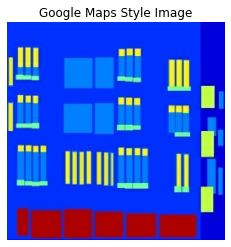

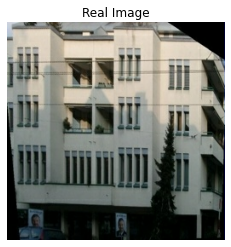

In [41]:
# Load an example image using the load function defined earlier
inp, re = load(PATH + 'train/1.jpg')

# Display the Google Maps style image (inp)
plt.figure()
plt.imshow(inp / 255.0)  # Normalize and display the Google Maps style image
plt.title('Google Maps Style Image') 
plt.axis('off')  
plt.show()  

# Display the real image (re)
plt.figure()
plt.imshow(re / 255.0)  # Normalize and display the real image
plt.title('Real Image')  
plt.axis('off') 
plt.show()  

In [42]:
#IMAGE AUGMENTATION
def resize(input_image, real_image, height, width):
    # Resize input_image and real_image to the specified height and width using nearest neighbor interpolation
    input_image = tf.image.resize(input_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image

def random_crop(input_image, real_image):
    # Stack input_image and real_image along the 0th axis
    stacked_image = tf.stack([input_image, real_image], axis=0)
    
    # Randomly crop the stacked_image to IMG_HEIGHT x IMG_WIDTH
    cropped_image = tf.image.random_crop(stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]

def normalize(input_image, real_image):
    # Normalize input_image and real_image to the range [-1, 1]
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

In [43]:
@tf.function()
def random_jitter(input_image, real_image):
    # Resize both input_image and real_image to 286 x 286 pixels
    input_image, real_image = resize(input_image, real_image, 286, 286)

    # Randomly crop both images to 256 x 256 pixels
    input_image, real_image = random_crop(input_image, real_image)

    # Randomly flip both images horizontally with a probability of 50%
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image

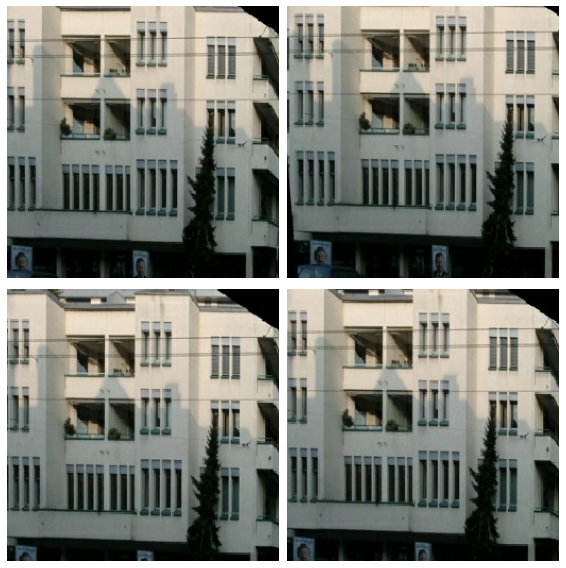

In [44]:
plt.figure(figsize=(8, 8))
for i in range(4):
    rj_inp, rj_re = random_jitter(inp, re)  # Apply random_jitter to inp and re
    plt.subplot(2, 2, i+1)
    plt.imshow(rj_re / 255.0)  # Display the real image after jitter, normalized
    plt.axis('off')  # Turn off axis labels
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [45]:
# LOAD IMAGES
# random jitter for training images
# resize test

def load_image_train(image_file):
    # Load the image using the load function
    input_image, real_image = load(image_file)
    
    # Apply random jitter for data augmentation
    input_image, real_image = random_jitter(input_image, real_image)
    
    # Normalize the images
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

In [46]:
def load_image_test(image_file):
    # Load the image using the load function
    input_image, real_image = load(image_file)
    
    # Resize the image to IMG_HEIGHT x IMG_WIDTH
    input_image, real_image = resize(input_image, real_image, IMG_HEIGHT, IMG_WIDTH)
    
    # Normalize the images
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

In [47]:
#IMPUT PIPELINE
# Create a dataset of file paths to training images
train_dataset = tf.data.Dataset.list_files(PATH + 'train/*.jpg')
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)   # Shuffle the dataset to ensure randomness in training
train_dataset = train_dataset.batch(BATCH_SIZE)    # Batch the dataset into batches of size BATCH_SIZE
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)   # Optimize performance by prefetching data batches automatically

# Create a dataset of file paths to validation (test) images
test_dataset = tf.data.Dataset.list_files(PATH + 'val/*.jpg')
test_dataset = test_dataset.map(load_image_test)   # Map the load_image_test function to load and preprocess each test image
test_dataset = test_dataset.batch(BATCH_SIZE)    # Batch the test dataset into batches of size BATCH_SIZE

In [48]:
# Create datasets for both training and validation file paths
a = tf.data.Dataset.list_files(PATH + 'train/*.jpg')
b = tf.data.Dataset.list_files(PATH + 'val/*.jpg')

# Concatenate both datasets into a single dataset
complete_dataset = a.concatenate(b)

# Map the load_image_train function to load and preprocess each image in parallel
complete_dataset = complete_dataset.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle the dataset to ensure randomness in training
complete_dataset = complete_dataset.shuffle(BUFFER_SIZE)

# Batch the dataset into batches of size BATCH_SIZE
complete_dataset = complete_dataset.batch(BATCH_SIZE)

# Optimize performance by prefetching data batches automatically
complete_dataset = complete_dataset.prefetch(tf.data.AUTOTUNE)

In [49]:
#GENERATOR MODEL
OUTPUT_CHANNELS = 3

In [50]:
def downsample(filters, size, apply_batchnorm=True):
    # Random weight initializer
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    # Convolutional layer with specified filters, kernel size, and stride=2 for downsampling
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.LeakyReLU())

    return result

In [51]:
def upsample(filters, size, apply_dropout=False):
    # Random weight initializer
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    # Conv2DTranspose layer for upsampling
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, 
                                        size,    
                                        strides=2,  
                                        padding='same',   
                                        kernel_initializer=initializer,  
                                        use_bias=False))  

    result.add(tf.keras.layers.BatchNormalization())

    # Optional dropout layer to prevent overfitting
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))  # Dropout rate of 0.5 (50% dropout)
    result.add(tf.keras.layers.ReLU())

    return result


In [52]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    #stack for downsample with dimensions
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (bs, 128, 128,  64)
        downsample(128, 4),                        # (bs,  64,  64, 128)
        downsample(256, 4),                        # (bs,  32,  32, 256)
        downsample(512, 4),                        # (bs,  16,  16, 512)
        downsample(512, 4),                        # (bs,   8,   8, 512)
        downsample(512, 4),                        # (bs,   4,   4, 512)
        downsample(512, 4),                        # (bs,   2,   2, 512)
        downsample(512, 4),                        # (bs,   1,   1, 512)
    ]
    #stack for upsample with dimensions
    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (bs,   2,   2, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs,   4,   4, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs,   8,   8, 1024)
        upsample(512, 4),                      # (bs,  16,  16, 1024)
        upsample(256, 4),                      # (bs,  32,  32,  512)
        upsample(128, 4),                      # (bs,  64,  64,  256)
        upsample(64, 4),                       # (bs, 128, 128,  128)
    ]

    #random initializer for last Conv2DTranspose
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS,
                                         4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (bs, 256, 256, 3)

    # x as input
    x = inputs

    # Downsampling through the model
    skips = []
    #get x through each downsample block and add result to skips
    for down in down_stack:
        x = down(x)
        skips.append(x)


    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    # for each upsample block concatenate skip connection
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    #use last Conv2DTranspose for imeage export
    x = last(x)

    #export model
    return tf.keras.Model(inputs=inputs, outputs=x)

In [53]:
generator = Generator()

In [54]:
#GENERATOR LOSS
LAMBDA = 100

In [55]:
#binary Crossentropy for generator
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [56]:
def generator_loss(disc_generated_output, gen_output, target):
    #cross entropy from 1's and generator
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # mean absolute error L1 Loss
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    # gan_loss + LAMBDA * L1
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

In [57]:
#DISCRIMINATOR
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar])  # (bs, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x)  # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (bs, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [58]:
discriminator = Discriminator()

In [59]:
#Discriminator LOSS
def discriminator_loss(disc_real_output, disc_generated_output):
    #corss entropy with ones (real images) 
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    #make generator Loss with zeros (these are the fake images)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    #add real_loss and loss from generator
    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [60]:
#generate optimizers for generator and discriminator
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [61]:
#GENERATE IMAGES
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

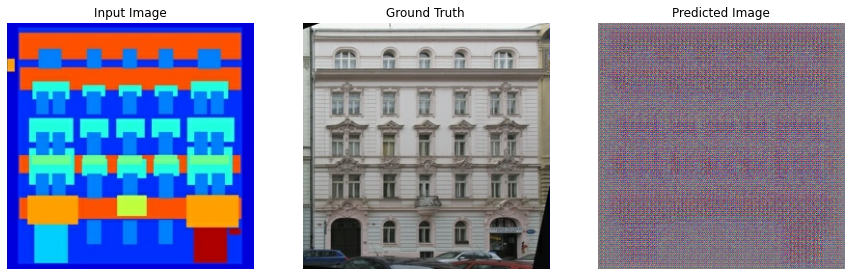

In [62]:
for example_input, example_target in test_dataset.take(1):
    generate_images(generator, example_input, example_target)

In [63]:
#TRAINING
#define checkpoints
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator,
                                 step=tf.Variable(0))

manager = tf.train.CheckpointManager(checkpoint, checkpoints_path, max_to_keep=2)

#logging
summary_writer = tf.summary.create_file_writer(log_path)

In [64]:
@tf.function
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        #generate image from generator with input_image for conditional GAN
        gen_output = generator(input_image, training=True)

        #generate loss for discriminator and generator
        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        #combine loss
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    #generate gradients from tape
    generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #apply gradients on optimizer (Backpropagation)
    generator_optimizer.apply_gradients(zip(generator_gradients,generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,discriminator.trainable_variables))

    #logging
    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
        tf.summary.scalar('disc_loss', disc_loss, step=epoch)

In [65]:
def fit(train_ds, epochs, test_ds):
    for epoch in range(epochs):
        for n, (input_image, target) in train_ds.enumerate():
            train_step(input_image, target, epoch)        
        
    save_path = manager.save()

In [ ]:
#START TRAINING
fit(complete_dataset, EPOCHS, test_dataset)

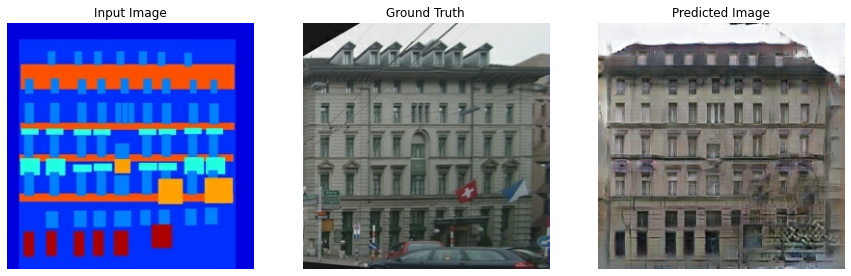

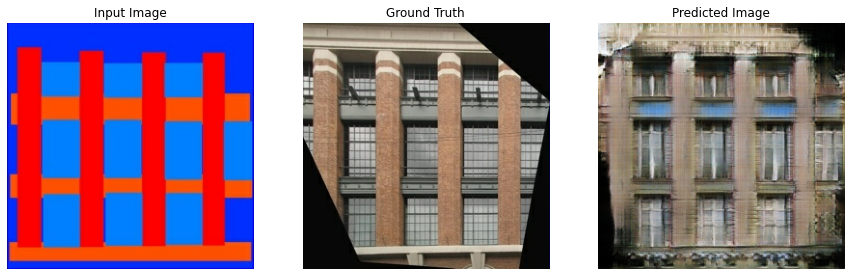

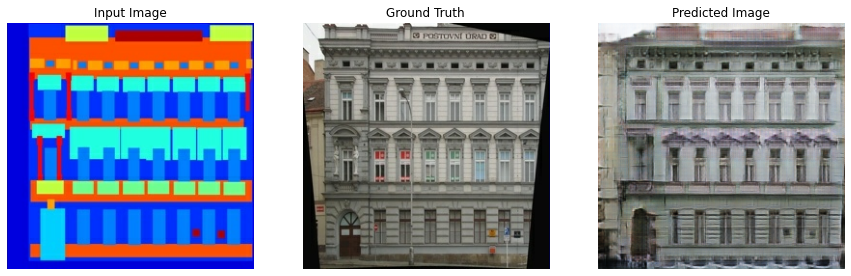

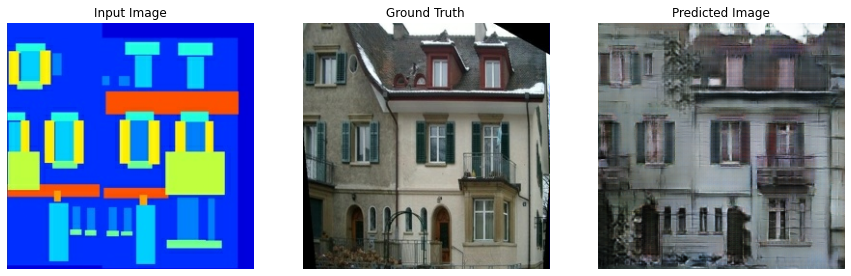

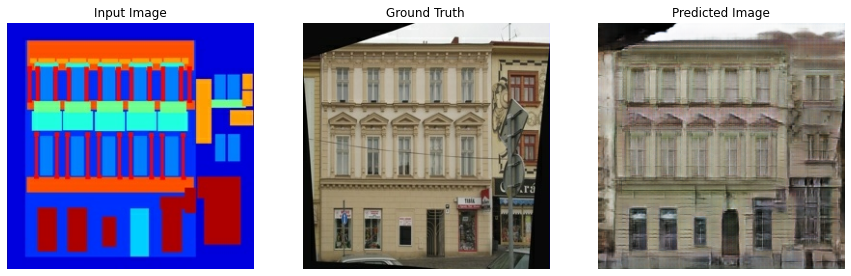

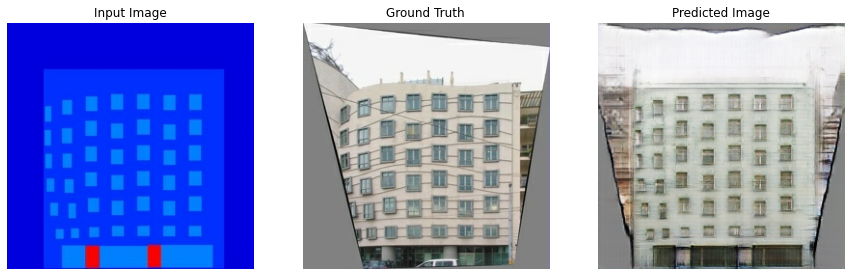

In [67]:
# Generate Image with best Model
for inp, tar in test_dataset.take(6):
    generate_images(generator, inp, tar)